# Data Processing and Modeling for Zillow's Home Value Prediction

The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016

The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.

You are asked to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

Not all the properties are sold in each time period. If a property was not sold in a certain time period, that particular row will be ignored when calculating your score.

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
import src.data_proc as data_proc

In [3]:
%%time
# Load in the data
train_2016 = pd.read_csv("data/train_2016_v2.csv")
prop = pd.read_csv("data/properties_2016.csv", dtype={
    'propertycountylandusecode': str,
    'hashottuborspa': str,
    'propertyzoningdesc': str,
    'fireplaceflag': str,
    'taxdelinquencyflag': str
})

# Parse the flag attributes
def convert_true_to_float(df, col):
    df.loc[df[col] == 'true', col] = '1'
    df.loc[df[col] == 'Y', col] = '1'
    df[col] = df[col].astype(float)

for col in ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']:
    convert_true_to_float(prop, col)

CPU times: user 18.6 s, sys: 3.67 s, total: 22.3 s
Wall time: 22.4 s


In [ ]:
# Take a quick look at the data
train_2016.head()

In [ ]:
prop.head(30)

In [ ]:
print("Number of transaction records: {}".format(len(train_2016)))
print("Number of properties: {}".format(len(prop)))
print("Number of property features: {}".format(len(prop.columns)-1))

In [4]:
# Rename & retype the feature columns; also unify representations of missing values
data_proc.rename_columns(prop)
data_proc.retype_columns(prop)
print(prop.info())
prop.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                   int64
cooling_id                 category
architecture_style_id      category
basement_sqft              float32
bathroom_cnt               float32
bedroom_cnt                float32
framing_id                 category
quality_id                 category
bathroom_cnt_calc          float32
deck_id                    float32
floor1_sqft                float32
finished_area_sqft_calc    float32
finished_area_sqft         float32
perimeter_area             float32
total_area                 float32
floor1_sqft_unk            float32
base_total_area            float32
fips                       category
fireplace_cnt              float32
bathroom_full_cnt          float32
garage_cnt                 float32
garage_sqft                float32
spa_flag                   float32
heating_id                 category
latitude                   float32
longitud

,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,10754147,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,238,NaN,60378004.0,37688.0,1815,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,230,LCA11*,60378000.0,37688.0,1815,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,16,LAC2,60377032.0,51617.0,1815,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.369141,NaN,NaN,NaN
3,10859147,-1,-1,NaN,0.0,0.0,2,6,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,16,LAC2,60371412.0,12447.0,1815,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.570312,NaN,NaN,NaN
4,10879947,-1,-1,NaN,0.0,0.0,3,-1,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,0,LAM1,60371232.0,12447.0,1815,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.169922,NaN,NaN,NaN
5,10898347,-1,-1,NaN,0.0,0.0,3,6,NaN,NaN,NaN,2400.0,NaN,NaN,2400.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34171872.0,-118380904.0,2500.0,NaN,NaN,NaN,NaN,NaN,1210,0,LAC4,60371252.0,12447.0,1815,46795.0,96446.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1943.0,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.280029,NaN,NaN,NaN
6,10933547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34131928.0,-118351472.0,NaN,NaN,NaN,NaN,NaN,NaN,010V,229,LAC2,60371436.0,12447.0,1815,274049.0,96049.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,397945.0,554573.0,2015.0,156628.0,6773.339844,NaN,NaN,NaN
7,10940747,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,3611.0,NaN,NaN,3611.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34171344.0,-118314896.0,5333.0,NaN,NaN,NaN,NaN,NaN,1210,0,BUC4YY,60373108.0,396054.0,1815,NaN,96434.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1946.0,1.0,NaN,101998.0,688486.0,2015.0,586488.0,7857.839844,NaN,NaN,NaN
8,10954547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34218208.0,-118331312.0,145865.0,NaN,NaN,NaN,NaN,NaN,010D,238,BUR1*,60373100.0,396054.0,1815,NaN,96436.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
9,10976347,-1,-1,NaN,0.0,0.0,2,6,NaN,NaN,NaN,3754.0,NaN,NaN,3754.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34289776.0,-118432088.0,7494.0,NaN,NaN,NaN,NaN,NaN,1210,0,SFC2*,60373204.0,47547.0,1815,NaN,96366.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1978.0,1.0,NaN,218440.0,261201.0,2015.0,42761.0,4054.760010,NaN,NaN,NaN


In [5]:
# Join the training data with the property table
train_2016 = train_2016.merge(how='left', right=prop, on='parcelid')

# Remove outliers from training set
threshold = 0.6
print("{} training examples in total".format(len(train_2016)))
print("{} with abs(logerror) > {}".format((abs(train_2016.logerror) > threshold).sum(), threshold))

train_2016 = train_2016[abs(train_2016.logerror) <= threshold]
print("New training set size (outliers removed): {}".format(len(train_2016)))

# Look at how complete (i.e. no missing value) each training set feature is
data_proc.print_complete_percentage(train_2016)
train_2016.head(30)

90275 training examples in total
951 with abs(logerror) > 0.6
New training set size (outliers removed): 89324
parcelid: 1.0
logerror: 1.0
transactiondate: 1.0
bathroom_cnt: 1.0
bedroom_cnt: 1.0
fips: 1.0
latitude: 1.0
longitude: 1.0
landuse_type_id: 1.0
census_1: 1.0
county_id: 1.0
room_cnt: 1.0
tax_year: 1.0
county_landuse_code: 0.9999888048005016
tax_parcel: 0.9999888048005016
tax_land: 0.9999888048005016
tax_property: 0.9999328288030093
region_zip: 0.999630558416551
tax_structure: 0.9959585329810577
census_2: 0.9933612466974161
finished_area_sqft_calc: 0.9928686579194841
year_built: 0.9918498947651248
bathroom_cnt_calc: 0.9873158389682504
bathroom_full_cnt: 0.9873158389682504
city_id: 0.9800053736957592
finished_area_sqft: 0.9491625990775155
lot_sqft: 0.8871188034570776
unit_cnt: 0.6452017374949621
zoning_description: 0.6446195871210425
quality_id: 0.6344655411759438
heating_id: 0.621210424969773
neighborhood_id: 0.39816846536205275
garage_cnt: 0.3331355514755273
garage_sqft: 0.3331

,parcelid,logerror,transactiondate,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,11016594,0.0276,2016-01-01,0,-1,NaN,2.0,3.0,-1,3,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,230,LARS,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,-1,-1,NaN,3.5,4.0,-1,-1,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,230,NaN,60590524.0,32380.0,0,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,0,-1,NaN,3.0,2.0,-1,3,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,230,PSR6,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,0,-1,NaN,2.0,2.0,-1,3,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,235,LAR3,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,-1,-1,NaN,2.5,4.0,-1,-1,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,230,NaN,60590424.0,17686.0,0,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,0,-1,NaN,4.0,4.0,-1,0,4.0,NaN,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,NaN,0100,230,HBR3YY,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,-1,-1,NaN,1.0,2.0,-1,6,1.0,NaN,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,NaN,0100,230,CORH*,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,-1,-1,NaN,2.5,3.0,-1,-1,2.5,NaN,853.0,1763.0,1763.0,NaN,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,235,NaN,61110032.0,13150.0,775,NaN,97101.0,6.0,NaN,1.0,-1,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,-1,-1,NaN,1.0,2.0,-1,-1,1.0,NaN,NaN,796.0,796.0,NaN,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,-1,-1,NaN,2.0,2.0,-1,-1,2.0,NaN,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,-1,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960.0,2015.0,80983

In [6]:
# Prepare data for LightGBM
lgb_label = train_2016.logerror.astype(np.float32)

# Drop features that are not useful or too messy
def drop_features(features):
    unused_feature_list = ['parcelid', 'logerror']  # not features
    unused_feature_list += ['tax_year']  # Not useful
    unused_feature_list += ['framing_id', 'construction_id', 'deck_id', 'pool_unk_1', 'pool_unk_2',
                           'architecture_style_id', 'story_id', 'perimeter_area', 'pool_total_size'] # too many missing
    unused_feature_list += ['latitude', 'longitude']  # Maybe?
    unused_feature_list += ['county_landuse_code', 'zoning_description']  # cannot be used directly
    unused_feature_list += ['transactiondate']  # Should definitely extract feature from this
    return features.drop(unused_feature_list, axis=1, errors='ignore')

lgb_features = drop_features(train_2016)
print("Number of features for LightGBM: {}".format(len(lgb_features.columns)))
lgb_features.head(10)

Number of features for LightGBM: 43


,cooling_id,basement_sqft,bathroom_cnt,bedroom_cnt,quality_id,bathroom_cnt_calc,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,lot_sqft,pool_cnt,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,bathroom_small_cnt,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,0,NaN,2.0,3.0,3,2.0,NaN,1684.0,1684.0,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,7528.0,NaN,NaN,230,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,-1,NaN,3.5,4.0,-1,3.5,NaN,2263.0,2263.0,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,3643.0,NaN,NaN,230,60590524.0,32380.0,0,NaN,96962.0,0.0,1.0,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,239071.0,10153.019531,NaN,NaN,NaN
2,0,NaN,3.0,2.0,3,3.0,NaN,2217.0,2217.0,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,11423.0,NaN,NaN,230,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,0,NaN,2.0,2.0,3,2.0,NaN,839.0,839.0,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,70859.0,NaN,NaN,235,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,-1,NaN,2.5,4.0,-1,2.5,NaN,2283.0,2283.0,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,6000.0,1.0,1.0,230,60590424.0,17686.0,0,NaN,96961.0,8.0,1.0,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,264977.0,5488.959961,NaN,NaN,6.059042e+13
5,0,NaN,4.0,4.0,0,4.0,NaN,3067.0,3067.0,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,2708.0,NaN,NaN,230,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13
6,-1,NaN,1.0,2.0,6,1.0,NaN,1297.0,1297.0,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,6677.0,NaN,NaN,230,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,46972.0,2304.969971,NaN,NaN,6.037542e+13
7,-1,NaN,2.5,3.0,-1,2.5,853.0,1763.0,1763.0,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,NaN,NaN,NaN,235,61110032.0,13150.0,775,NaN,97101.0,6.0,1.0,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,199000.0,3745.500000,NaN,NaN,6.111003e+13
8,-1,NaN,1.0,2.0,-1,1.0,NaN,796.0,796.0,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,NaN,NaN,NaN,235,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,143230.0,2172.879883,NaN,NaN,6.059042e+13
9,-1,NaN,2.0,2.0,-1,2.0,NaN,1260.0,1260.0,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,NaN,NaN,NaN,235,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960.0,80983.0,1940.260010,NaN,NaN,6.059063e+13


In [7]:
# Transform to Numpy matrices and perform train/val split
lgb_X = lgb_features.values
lgb_y = lgb_label.values

np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (66993, 43)
y_train shape: (66993,)
X_val shape: (22331, 43)
y_val shape: (22331,)


In [8]:
# LightGBM parameters
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4  # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 2000
params['learning_rate'] = 0.001  # shrinkage_rate
params['early_stopping_rounds'] = 20  # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 512  # max number of leaves in one tree (default 31)
params['min_data'] = 175  # min_data_in_leaf
params['min_hessian'] = 0.05  # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1  # limit the max depth of tree model, defult -1 (no limit)
params['max_bin'] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params['sub_feature'] = 0.7    # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params['bagging_fraction'] = 0.75
params['bagging_freq'] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 10.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [9]:
# Train LightGBM
feature_names = [s for s in lgb_features.columns]
categorical_indices = []
for i, t in enumerate(lgb_features.dtypes):
    if t.name == 'category':
        categorical_indices.append(i)

lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
clf = lgb.train(params, lgb_train_set, verbose_eval=True,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on validation set
print("Train score: {}".format(abs(clf.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(clf.predict(X_val) - y_val).mean() * 100))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 4, 12, 18, 22, 25]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's l1: 0.056921	val's l1: 0.058013
Training until validation scores don't improve for 20 rounds.
[2]	train's l1: 0.0569188	val's l1: 0.0580117
[3]	train's l1: 0.0569166	val's l1: 0.0580104
[4]	train's l1: 0.0569144	val's l1: 0.058009
[5]	train's l1: 0.0569117	val's l1: 0.0580073
[6]	train's l1: 0.0569096	val's l1: 0.0580061
[7]	train's l1: 0.056907	val's l1: 0.0580044
[8]	train's l1: 0.0569044	val's l1: 0.0580025
[9]	train's l1: 0.056902	val's l1: 0.058001
[10]	train's l1: 0.0568998	val's l1: 0.0579997
[11]	train's l1: 0.0568974	val's l1: 0.057998
[12]	train's l1: 0.056895	val's l1: 0.0579965
[13]	train's l1: 0.0568929	val's l1: 0.0579951
[14]	train's l1: 0.0568902	val's l1: 0.0579934
[15]	train's l1: 0.0568881	val's l1: 0.0579922
[16]	train's l1: 0.056886	val's l1: 0.057991
[17]	train's l1: 0.0568834	val's l1: 0.0579892
[18]	train's l1: 0.0568814	val's l1: 0.057988
[19]	train's l1: 0.0568787	val's l1: 0.0579863
[20]	train's l1: 0.0568763	val's l1: 0.0579847
[21]	train's l1: 0

[178]	train's l1: 0.0565357	val's l1: 0.0577771
[179]	train's l1: 0.0565339	val's l1: 0.0577759
[180]	train's l1: 0.0565322	val's l1: 0.057775
[181]	train's l1: 0.0565304	val's l1: 0.0577742
[182]	train's l1: 0.0565283	val's l1: 0.0577729
[183]	train's l1: 0.0565267	val's l1: 0.0577719
[184]	train's l1: 0.0565247	val's l1: 0.0577706
[185]	train's l1: 0.056523	val's l1: 0.0577695
[186]	train's l1: 0.0565209	val's l1: 0.0577683
[187]	train's l1: 0.056519	val's l1: 0.0577671
[188]	train's l1: 0.0565171	val's l1: 0.0577659
[189]	train's l1: 0.0565148	val's l1: 0.0577646
[190]	train's l1: 0.0565128	val's l1: 0.0577631
[191]	train's l1: 0.0565111	val's l1: 0.0577623
[192]	train's l1: 0.0565094	val's l1: 0.0577615
[193]	train's l1: 0.0565074	val's l1: 0.0577603
[194]	train's l1: 0.0565057	val's l1: 0.0577594
[195]	train's l1: 0.0565038	val's l1: 0.0577585
[196]	train's l1: 0.0565022	val's l1: 0.0577576
[197]	train's l1: 0.0565001	val's l1: 0.0577565
[198]	train's l1: 0.056498	val's l1: 0.0577

[355]	train's l1: 0.0562169	val's l1: 0.0575987
[356]	train's l1: 0.0562155	val's l1: 0.0575982
[357]	train's l1: 0.056214	val's l1: 0.0575975
[358]	train's l1: 0.0562123	val's l1: 0.0575966
[359]	train's l1: 0.0562104	val's l1: 0.0575956
[360]	train's l1: 0.0562087	val's l1: 0.0575948
[361]	train's l1: 0.0562071	val's l1: 0.057594
[362]	train's l1: 0.0562054	val's l1: 0.0575932
[363]	train's l1: 0.0562037	val's l1: 0.0575922
[364]	train's l1: 0.0562021	val's l1: 0.0575914
[365]	train's l1: 0.0562003	val's l1: 0.0575905
[366]	train's l1: 0.0561986	val's l1: 0.0575895
[367]	train's l1: 0.056197	val's l1: 0.0575887
[368]	train's l1: 0.0561952	val's l1: 0.0575877
[369]	train's l1: 0.0561937	val's l1: 0.0575869
[370]	train's l1: 0.0561921	val's l1: 0.0575862
[371]	train's l1: 0.0561906	val's l1: 0.0575856
[372]	train's l1: 0.0561888	val's l1: 0.0575848
[373]	train's l1: 0.0561871	val's l1: 0.057584
[374]	train's l1: 0.0561854	val's l1: 0.0575833
[375]	train's l1: 0.0561836	val's l1: 0.0575

[527]	train's l1: 0.0559509	val's l1: 0.0574687
[528]	train's l1: 0.0559496	val's l1: 0.0574683
[529]	train's l1: 0.0559483	val's l1: 0.0574678
[530]	train's l1: 0.0559468	val's l1: 0.0574672
[531]	train's l1: 0.0559453	val's l1: 0.0574664
[532]	train's l1: 0.0559439	val's l1: 0.0574658
[533]	train's l1: 0.0559425	val's l1: 0.0574651
[534]	train's l1: 0.055941	val's l1: 0.0574643
[535]	train's l1: 0.0559399	val's l1: 0.0574638
[536]	train's l1: 0.0559385	val's l1: 0.0574631
[537]	train's l1: 0.0559372	val's l1: 0.0574627
[538]	train's l1: 0.0559356	val's l1: 0.0574621
[539]	train's l1: 0.0559343	val's l1: 0.0574616
[540]	train's l1: 0.0559329	val's l1: 0.0574611
[541]	train's l1: 0.0559315	val's l1: 0.0574604
[542]	train's l1: 0.0559303	val's l1: 0.05746
[543]	train's l1: 0.055929	val's l1: 0.0574594
[544]	train's l1: 0.0559275	val's l1: 0.0574587
[545]	train's l1: 0.055926	val's l1: 0.0574581
[546]	train's l1: 0.0559248	val's l1: 0.0574575
[547]	train's l1: 0.0559234	val's l1: 0.05745

[713]	train's l1: 0.0557084	val's l1: 0.0573791
[714]	train's l1: 0.0557072	val's l1: 0.0573788
[715]	train's l1: 0.0557061	val's l1: 0.0573786
[716]	train's l1: 0.0557048	val's l1: 0.0573781
[717]	train's l1: 0.0557035	val's l1: 0.0573776
[718]	train's l1: 0.0557023	val's l1: 0.0573775
[719]	train's l1: 0.0557012	val's l1: 0.0573772
[720]	train's l1: 0.0556999	val's l1: 0.0573767
[721]	train's l1: 0.0556987	val's l1: 0.0573763
[722]	train's l1: 0.0556975	val's l1: 0.057376
[723]	train's l1: 0.0556964	val's l1: 0.0573758
[724]	train's l1: 0.0556952	val's l1: 0.0573754
[725]	train's l1: 0.055694	val's l1: 0.0573751
[726]	train's l1: 0.0556929	val's l1: 0.0573748
[727]	train's l1: 0.0556918	val's l1: 0.0573744
[728]	train's l1: 0.0556906	val's l1: 0.057374
[729]	train's l1: 0.0556893	val's l1: 0.0573735
[730]	train's l1: 0.0556882	val's l1: 0.0573734
[731]	train's l1: 0.0556869	val's l1: 0.057373
[732]	train's l1: 0.0556857	val's l1: 0.0573726
[733]	train's l1: 0.0556846	val's l1: 0.0573

[887]	train's l1: 0.0555104	val's l1: 0.0573199
[888]	train's l1: 0.0555093	val's l1: 0.0573196
[889]	train's l1: 0.0555082	val's l1: 0.0573192
[890]	train's l1: 0.0555072	val's l1: 0.0573191
[891]	train's l1: 0.0555062	val's l1: 0.0573188
[892]	train's l1: 0.055505	val's l1: 0.0573186
[893]	train's l1: 0.055504	val's l1: 0.0573183
[894]	train's l1: 0.0555029	val's l1: 0.057318
[895]	train's l1: 0.0555018	val's l1: 0.0573178
[896]	train's l1: 0.0555007	val's l1: 0.0573174
[897]	train's l1: 0.0554998	val's l1: 0.0573172
[898]	train's l1: 0.0554987	val's l1: 0.057317
[899]	train's l1: 0.0554977	val's l1: 0.0573168
[900]	train's l1: 0.0554965	val's l1: 0.0573166
[901]	train's l1: 0.0554955	val's l1: 0.0573165
[902]	train's l1: 0.0554943	val's l1: 0.0573162
[903]	train's l1: 0.0554932	val's l1: 0.0573161
[904]	train's l1: 0.0554921	val's l1: 0.0573159
[905]	train's l1: 0.055491	val's l1: 0.0573154
[906]	train's l1: 0.0554898	val's l1: 0.057315
[907]	train's l1: 0.0554887	val's l1: 0.057314

[1067]	train's l1: 0.0553268	val's l1: 0.0572823
[1068]	train's l1: 0.0553258	val's l1: 0.0572822
[1069]	train's l1: 0.0553248	val's l1: 0.0572819
[1070]	train's l1: 0.0553237	val's l1: 0.0572816
[1071]	train's l1: 0.0553228	val's l1: 0.0572816
[1072]	train's l1: 0.0553217	val's l1: 0.0572813
[1073]	train's l1: 0.0553208	val's l1: 0.0572811
[1074]	train's l1: 0.0553197	val's l1: 0.0572807
[1075]	train's l1: 0.0553187	val's l1: 0.0572804
[1076]	train's l1: 0.0553177	val's l1: 0.0572801
[1077]	train's l1: 0.0553167	val's l1: 0.0572798
[1078]	train's l1: 0.0553156	val's l1: 0.0572795
[1079]	train's l1: 0.0553146	val's l1: 0.0572793
[1080]	train's l1: 0.0553135	val's l1: 0.0572791
[1081]	train's l1: 0.0553125	val's l1: 0.0572787
[1082]	train's l1: 0.0553114	val's l1: 0.0572785
[1083]	train's l1: 0.0553105	val's l1: 0.0572782
[1084]	train's l1: 0.0553095	val's l1: 0.0572779
[1085]	train's l1: 0.0553085	val's l1: 0.0572776
[1086]	train's l1: 0.0553076	val's l1: 0.0572773
[1087]	train's l1: 0

[1246]	train's l1: 0.0551606	val's l1: 0.0572571
[1247]	train's l1: 0.0551598	val's l1: 0.057257
[1248]	train's l1: 0.0551589	val's l1: 0.057257
[1249]	train's l1: 0.055158	val's l1: 0.0572568
[1250]	train's l1: 0.0551572	val's l1: 0.0572566
[1251]	train's l1: 0.0551564	val's l1: 0.0572566
[1252]	train's l1: 0.0551555	val's l1: 0.0572566
[1253]	train's l1: 0.0551546	val's l1: 0.0572564
[1254]	train's l1: 0.0551536	val's l1: 0.0572564
[1255]	train's l1: 0.0551526	val's l1: 0.0572562
[1256]	train's l1: 0.0551516	val's l1: 0.0572561
[1257]	train's l1: 0.0551507	val's l1: 0.0572559
[1258]	train's l1: 0.0551498	val's l1: 0.0572558
[1259]	train's l1: 0.0551489	val's l1: 0.0572557
[1260]	train's l1: 0.055148	val's l1: 0.0572555
[1261]	train's l1: 0.055147	val's l1: 0.0572552
[1262]	train's l1: 0.0551462	val's l1: 0.0572552
[1263]	train's l1: 0.0551454	val's l1: 0.0572551
[1264]	train's l1: 0.0551445	val's l1: 0.0572549
[1265]	train's l1: 0.0551436	val's l1: 0.0572548
[1266]	train's l1: 0.0551

[1415]	train's l1: 0.0550137	val's l1: 0.0572323
[1416]	train's l1: 0.0550129	val's l1: 0.0572321
[1417]	train's l1: 0.055012	val's l1: 0.057232
[1418]	train's l1: 0.0550111	val's l1: 0.0572319
[1419]	train's l1: 0.0550104	val's l1: 0.0572319
[1420]	train's l1: 0.0550096	val's l1: 0.0572318
[1421]	train's l1: 0.0550088	val's l1: 0.0572317
[1422]	train's l1: 0.0550079	val's l1: 0.0572317
[1423]	train's l1: 0.0550071	val's l1: 0.0572315
[1424]	train's l1: 0.0550063	val's l1: 0.0572314
[1425]	train's l1: 0.0550055	val's l1: 0.0572313
[1426]	train's l1: 0.0550048	val's l1: 0.0572311
[1427]	train's l1: 0.055004	val's l1: 0.0572312
[1428]	train's l1: 0.0550032	val's l1: 0.0572311
[1429]	train's l1: 0.0550025	val's l1: 0.0572311
[1430]	train's l1: 0.0550017	val's l1: 0.0572309
[1431]	train's l1: 0.0550009	val's l1: 0.0572308
[1432]	train's l1: 0.055	val's l1: 0.0572307
[1433]	train's l1: 0.0549993	val's l1: 0.0572307
[1434]	train's l1: 0.0549985	val's l1: 0.0572307
[1435]	train's l1: 0.054997

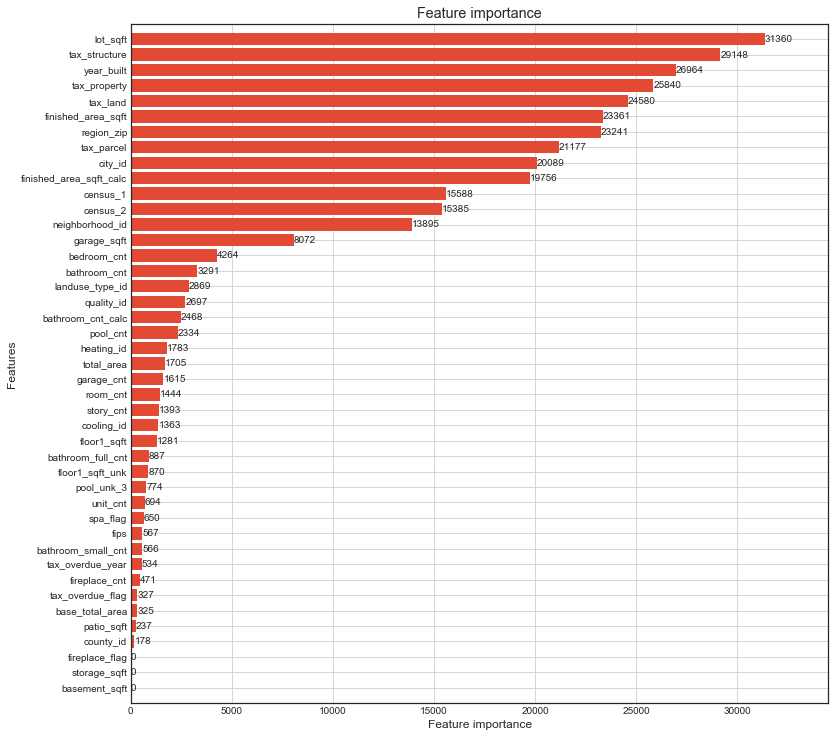

In [10]:
# Plot LightGBM feature importance
lgb.plot_importance(clf, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [ ]:
def predict_and_export(clf, prop, file_name):
    # Construct features and make prediction
    test_features = drop_features(prop)
    pred_test = clf.predict(test_features)
    
    # Export prediction results
    submission = pd.DataFrame()
    submission['ParcelId'] = prop.parcelid
    
    pred_test = [float(format(x, '.4f')) for x in pred_test]
    test_columns = ['201610','201611','201612','201710','201711','201712']
    for col in test_columns:
        submission[col] = pred_test
    
    print("Length of submission DataFrame: {}".format(len(submission)))
    print("Submission header:")
    print(submission.head())
    submission.to_csv(file_name, index=False)

predict_and_export(clf, prop, 'data/submission_181228_v3.csv')

In [ ]:
# Sweep a single hyperparameter
def sweep_hyperparam(param_name, sweep):
    feature_names = [s for s in lgb_features.columns]
    categorical_indices = []
    for i, t in enumerate(lgb_features.dtypes):
        if t.name == 'category':
            categorical_indices.append(i)

    lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
    lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

    train_scores = []
    val_scores = []
    for p in sweep:
        print(p)
        np.random.seed(42)
        random.seed(36)
        params[param_name] = p
        clf = lgb.train(params, lgb_train_set, verbose_eval=False,
                    valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                    categorical_feature=categorical_indices)
        train_scores.append(abs(clf.predict(X_train) - y_train).mean() * 100)
        val_scores.append(abs(clf.predict(X_val) - y_val).mean() * 100)

    for i in range(len(sweep)):
        print("{}: train {}, val {}".format(sweep[i], train_scores[i], val_scores[i]))

sweep_hyperparam('cat_smooth', [5.0, 10.0, 15.0, 20.0])